### 파일명 바꿔주기

In [1]:
import os
file_path = 'D:/UrbanSound8K/UrbanSound8K/audio/fold6'
file_names = os.listdir(file_path)
file_names

i = 1001
j = 929
for name in file_names:
    src = os.path.join(file_path, name)
    if(int(name.split('-')[1])==8):
        dst = 'siren' + str(j) + '.wav'
        j += 1        
        dst = os.path.join(file_path, dst)
        os.rename(src, dst)
    if(int(name.split('-')[1])==3):
        dst = 'dogbark' + str(i) + '.wav'
        i += 1        
        dst = os.path.join(file_path, dst)
        os.rename(src, dst)

### features 추출

In [1]:
import numpy as np
import pandas as pd
import glob
import librosa

def sound_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

In [2]:
files = glob.glob('D:/dataset3/*.wav')
rows = len(files)
features = np.zeros((rows, 193))
print(features.shape)

(41668, 193)


In [3]:
def parse_files(files): 
    index=0
    for filename in files:
        try:
            mfccs, chroma, mel, contrast, tonnetz = sound_feature(filename)
            exfeatures = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
        except:
            print("error " + filename)
        else:
            features[index] = exfeatures
            index+=1
    print(features)
    return features

In [ ]:
parse_files(files)

### label 원핫인코딩

In [4]:
import os
int_y = []
y = []

label_dict = {
    'dogbark' : 0,
    'siren' : 1,
    'babycry' : 2,
    'Doorbell' :3,
}

path = 'D:/dataset3'

In [5]:
for file_path in os.listdir(path) :
    if file_path[0] == '.' : 
        continue
    for item_key, item_val in label_dict.items():
        cur = np.zeros(len(label_dict)) 
        if item_key in file_path :
            cur[item_val] = 1 
            y.append(cur)
            int_y.append(item_val)

### 골고루 데이터 섞어주기

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.32, random_state=0)

stratSplit.get_n_splits(features, int_y)

for train_index, test_index in stratSplit.split(features, y):
    ##print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape)
print(y_train.shape)

X_train = X_train.reshape(X_train.shape[0], 193, 1)
X_test = X_test.reshape(X_test.shape[0], 193, 1)

In [9]:
np.save("X_train", X_train)
np.save("X_test", X_test)
np.save("y_train", y_train)
np.save("y_test", y_test)

In [7]:
X_test = np.load('X_test.npy') 
X_train = np.load('X_train.npy') 
y_test = np.load('y_test.npy')
y_train = np.load('y_train.npy')

### 학습

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, GRU
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 4)                 84        
Total params: 1,844
Trainable params: 1,844
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2834/2834 [==============================] - 88s 31ms/step - loss: 0.1707 - accuracy: 0.4485 - val_loss: 0.1377 - val_accuracy: 0.5756
Epoch 2/10
2834/2834 [==============================] - 93s 33ms/step - loss: 0.1334 - accuracy: 0.5920 - val_loss: 0.1310 - val_accuracy: 0.6176
Epoch 3/10
2834/2834 [==============================] - 94s 33ms/step - loss: 0.1160 - accuracy: 0.6633 - val_loss: 0.1074 - val_accuracy: 0.7062
Epoch 4/10
2834/2834 [==============================] - 95s 33ms/step - loss: 

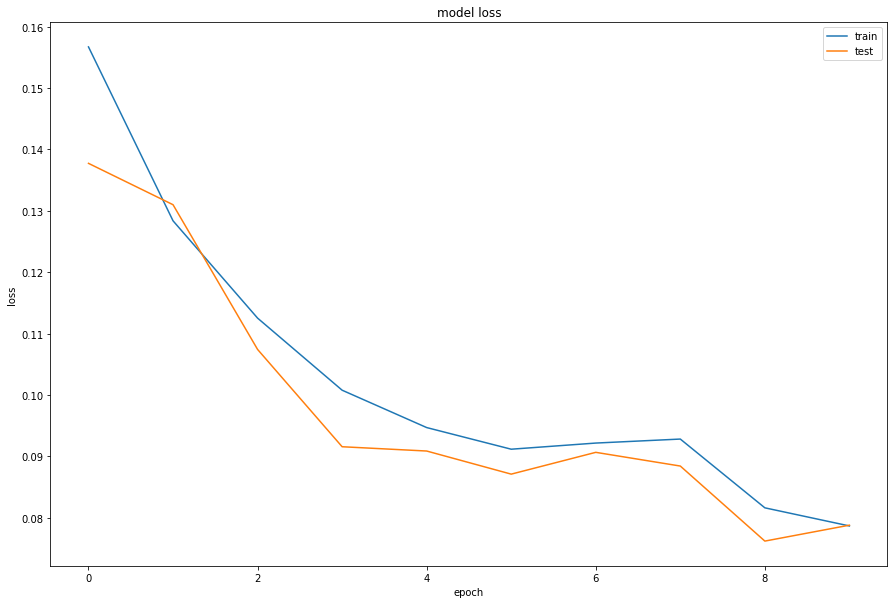

{'loss': [0.1567039042711258, 0.1283714771270752, 0.11252079904079437, 0.10077661275863647, 0.0946899875998497, 0.09116444736719131, 0.09216523915529251, 0.09281753748655319, 0.08161456137895584, 0.0786631628870964], 'accuracy': [0.5054351687431335, 0.6130443811416626, 0.6774193644523621, 0.7159596085548401, 0.7367473840713501, 0.7485706210136414, 0.7429943084716797, 0.7393590807914734, 0.7780758142471313, 0.785134494304657], 'val_loss': [0.137733593583107, 0.13099431991577148, 0.10741768777370453, 0.09156618267297745, 0.09086744487285614, 0.08710359781980515, 0.09065426886081696, 0.08842100948095322, 0.0761953741312027, 0.07878831028938293], 'val_accuracy': [0.5755962133407593, 0.6175941228866577, 0.7062397003173828, 0.7457627058029175, 0.755287230014801, 0.7638368010520935, 0.746437668800354, 0.7542372941970825, 0.7946602702140808, 0.7884355783462524]}
train loss= 0.0786631628870964
validation loss= 0.07878831028938293


In [9]:
def plot_loss_curve(history):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15,10))
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
def train_lstm_model(X_train, X_test):
    model = Sequential()
    model.add(LSTM(20, input_shape=(193, 1))) 
    model.add(Dense(4))
    model.summary()
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    earlystopping = EarlyStopping(monitor='loss', patience=1, verbose=1)
    
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=10, 
                        verbose=1)
    
    plot_loss_curve(history.history)
    
    print(history.history)
    
    print("train loss=",history.history['loss'][-1])
    print("validation loss=",history.history['val_loss'][-1])
    
    return model

model = train_lstm_model(X_train, X_test)


### predict 하기 위한 feature 추출

In [10]:
def parse_sound(files): 
    index=0
    try:
        mfccs, chroma, mel, contrast, tonnetz = sound_feature(files)
        exfeatures = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
    except:
        print("error " + filename)
    else:
        features[index] = exfeatures
        index+=1
    return features


### predict

In [11]:
def predict_sound(filename):
    X = parse_sound(filename)
    X = X[0]
    X = X.reshape(1,193,1)
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)[0]
    if y_pred == 0:
        print('개 짖는 소리가 들립니다!')
    elif y_pred == 1:
        print('siren 소리가 들립니다!')
    elif y_pred == 2:
        print('아기 울음 소리가 들립니다!')
    else:
        print('Doorbell 소리가 들립니다!')

In [12]:
predict_sound('dogbark6.wav')

개 짖는 소리가 들립니다!
